In [1]:
import pandas as pd
import numpy as np
from gensim.models import HdpModel
from gensim import corpora
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay, roc_auc_score, PrecisionRecallDisplay
from sklearn.svm import SVC

In [2]:
converter = lambda x: list(map(lambda y: y.strip("'"), x.strip("[]").split(", ")))
data = pd.read_csv('data/data.csv', converters={"Email" : converter, "Lemmatized" : converter}, index_col=0)
spamproportion = sum(data.Spam) / len(data)

Split the data into 80% training and 20% test sets (stratified):

In [76]:
kf1 = KFold(n_splits=5, shuffle=True, random_state=12)
outerfolds = list(kf1.split(data))
train, test = outerfolds[0]
#train, test = train_test_split(data, test_size=0.2, random_state=12, stratify=data.Spam)

Now split the training set into 10 folds for cross-validation

In [77]:
kf2 = KFold(n_splits=10, shuffle=True, random_state=47) # a specific random state is chosen for reproducibility only
innerfolds = list(kf2.split(train))

We implement a sort of naive classifier using the output of the topic model. It works like this:

* For each email, assign it to its modal topic (that is, the topic which the model assigns it the greatest probability of belonging to)
* For each topic, declare it to be a spam topic if the proportion of spam emails assigned to that topic exceeds a given threshold (this threshold is a parameter to the model)
* For each email, assign it a spam probability equal to the sum of the probabilities with which the model assigns it to each spam topic
* Declare an email to be spam if its spam probability exceeds some threshold (which is another parameter to the model)

In [60]:
def distarray(dist, numtopics):
    array = np.zeros((len(dist), numtopics))
    for i in range(len(dist)):
        for pair in dist[i]:
            topic, prob = pair
            array[i, topic] = prob
    return array

def naive_classifier(train, truth, threshold=0.5): # Takes a training dataset and ground truth, and returns a function to get spam probabilities from test data
    numtopics = len(train[0])
    numemails = len(train)
    spamcount = np.zeros(numtopics)
    emailcount = np.zeros(numtopics)
    spamtopic = np.zeros(numtopics)
    for i in range(numemails):
        email = train[i]
        topic = np.argmax(email)
        emailcount[topic] += 1
        if truth[i]:
            spamcount[topic] +=1
    for j in range(numtopics):
        if (emailcount[j] * threshold) < spamcount[j]:
            spamtopic[j] = 1
    return (lambda x: np.dot(x, spamtopic))

def upgraded_classifier(train, truth):
    numtopics = len(train[0])
    #totalprob = np.zeros(numtopics)
    #spamprob = np.zeros(numtopics)
    topicweight = np.zeros(numtopics)
    for i in range(numtopics):
        topic = train[:, i]
        totalprob = sum(topic)
        spamprob = np.dot(topic, truth)
        if totalprob == 0:
            topicweight[i] = 0
        else:
            topicweight[i] = spamprob / totalprob
    return (lambda x: np.dot(x, topicweight))

0
1
2
3
4
5
6
7
8
9


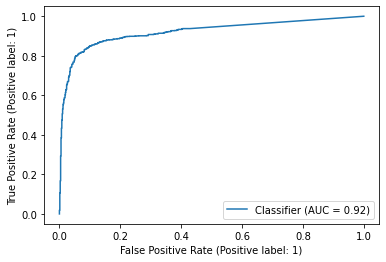

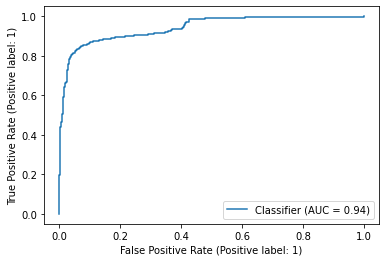

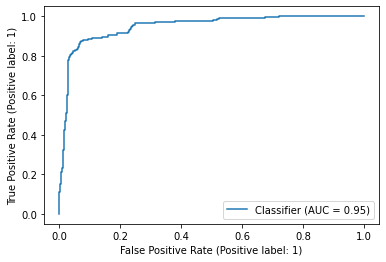

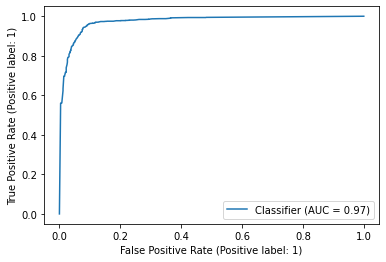

In [78]:
bestauc_nc = 0
bestauc_uc = 0
bestauc_svm = 0
bestauc_rf = 0
topic_models = []
dictionaries = []
nc_classifiers = []
uc_classifiers = []
svm_classifiers = []
rf_classifiers = []

i = 0
traindata = data.loc[train]
traindata.reset_index(drop=True, inplace=True)
for fold in innerfolds:
    innertrain, verify = fold
    innertraindata = traindata.loc[innertrain]
    testdata = traindata.loc[verify]
    dictionary = corpora.Dictionary(innertraindata.Lemmatized)
    dictionary.filter_extremes(no_below=15, no_above=0.5)
    dictionaries.append(dictionary)
    traincorpus = list(map(dictionary.doc2bow, innertraindata.Lemmatized))
    testcorpus = list(map(dictionary.doc2bow, testdata.Lemmatized))
    hdp = HdpModel(traincorpus, dictionary, random_state=63)
    topic_models.append(hdp)
    traindist = list(hdp[traincorpus])
    testdist = list(hdp[testcorpus])
    numtopics = len(hdp.get_topics())
    trainarray = distarray(traindist, numtopics)
    testarray = distarray(testdist, numtopics)
    trueresults = list(testdata.Spam)
    
    nc = naive_classifier(trainarray, list(innertraindata.Spam), threshold=spamproportion)
    nc_classifiers.append(nc)
    spamprobs = list(map(nc, testarray))
    #testresults = list(map(lambda x: x > 0.5, spamprobs))
    auc = roc_auc_score(trueresults, spamprobs)
    if auc > bestauc_nc:
        bestauc_nc = auc
        bestmodel_nc = hdp
        classifier_nc = nc
        bestsplit_nc = i
        true_nc = trueresults
        test_nc = spamprobs
        dict_nc = dictionary
        
    uc = upgraded_classifier(trainarray, list(innertraindata.Spam))
    uc_classifiers.append(uc)
    spamprobs = list(map(uc, testarray))
    #testresults = list(map(lambda x: x > 0.5, spamprobs))
    auc = roc_auc_score(trueresults, spamprobs)
    if auc > bestauc_uc:
        bestauc_uc = auc
        bestmodel_uc = hdp
        classifier_uc = uc
        bestsplit_uc = i
        true_uc = trueresults
        test_uc = spamprobs
        dict_uc = dictionary
        
    svm = SVC(random_state=63)
    svm = svm.fit(trainarray, innertraindata.Spam)
    svm_classifiers.append(svm)
    spamscores = svm.decision_function(testarray)
    #testresults = list(map(lambda x: x > 0.5, spamprobs))
    auc = roc_auc_score(trueresults, spamscores)
    if auc > bestauc_svm:
        bestauc_svm = auc
        bestmodel_svm = hdp
        classifier_svm = svm
        bestsplit_svm = i
        true_svm = trueresults
        test_svm = spamscores
        dict_svm = dictionary
        
    rf = RandomForestClassifier(random_state=63)
    rf = rf.fit(trainarray, innertraindata.Spam)
    rf_classifiers.append(rf)
    spamprobs = list(map(lambda x: x[1], rf.predict_proba(testarray)))
    #testresults = list(map(lambda x: x > 0.5, spamprobs))
    auc = roc_auc_score(trueresults, spamprobs)
    if auc > bestauc_rf:
        bestauc_rf = auc
        bestmodel_rf = hdp
        classifier_rf = rf
        bestsplit_rf = i
        true_rf = trueresults
        test_rf = spamprobs
        dict_rf = dictionary
        
    print(i)
    i += 1
    
RocCurveDisplay.from_predictions(true_nc, test_nc)
RocCurveDisplay.from_predictions(true_uc, test_uc)
RocCurveDisplay.from_predictions(true_svm, test_svm)
RocCurveDisplay.from_predictions(true_rf, test_rf)

We now test the model which scored best for AUC with each classifier on the reserved test dataset from earlier:

## Naive Classifier

In [96]:
testdata = data.loc[outerfolds[0][1]]
corpus = list(map(dict_nc.doc2bow, testdata.Lemmatized))
dist = list(bestmodel_nc[corpus])
numtopics = len(bestmodel_nc.get_topics())
array = distarray(dist, numtopics)
trueresults = list(testdata.Spam)

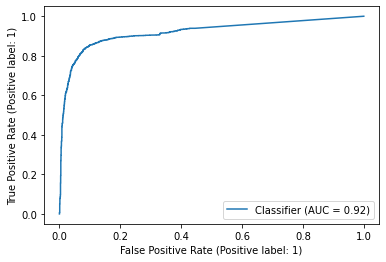

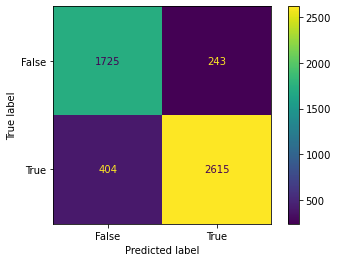

In [98]:
spamprobs = list(map(classifier_nc, array))
RocCurveDisplay.from_predictions(trueresults, spamprobs)
nc_results = list(map(lambda x: x > 0.5, spamprobs))
ConfusionMatrixDisplay.from_predictions(trueresults, nc_results)

## Upgraded Classifier

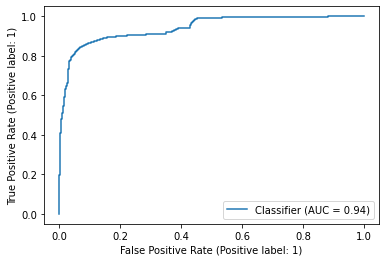

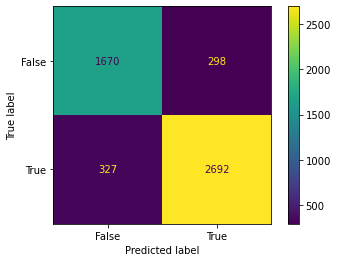

In [99]:
spamprobs = list(map(classifier_uc, array))
RocCurveDisplay.from_predictions(trueresults, spamprobs)
uc_results = list(map(lambda x: x > 0.5, spamprobs))
ConfusionMatrixDisplay.from_predictions(trueresults, uc_results)

## SVM

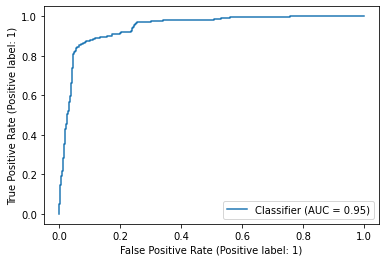

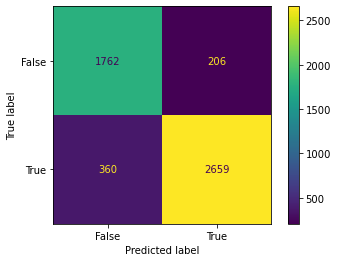

In [100]:
spamscores = classifier_svm.decision_function(array)
RocCurveDisplay.from_predictions(trueresults, spamscores)
svm_results = list(map(lambda x: x > 0, spamscores))
ConfusionMatrixDisplay.from_predictions(trueresults, svm_results)

## Random Forest

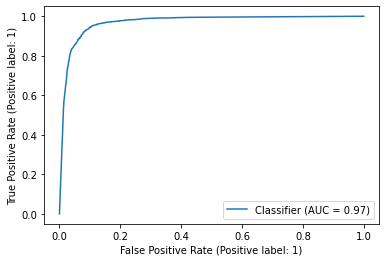

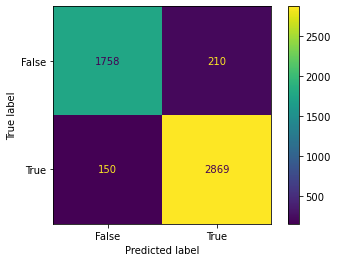

In [101]:
spamprobs = list(map(lambda x: x[1], classifier_rf.predict_proba(array)))
RocCurveDisplay.from_predictions(trueresults, spamprobs)
rf_results = list(map(lambda x: x > 0.5, spamprobs))
ConfusionMatrixDisplay.from_predictions(trueresults, rf_results)

# Voting Models

During the cross-validation phase, we trained 10 different topic models. Rather than waste these, we can try to combine these models to get a better classifier.

In [102]:
num_emails = len(testdata)
probarray_nc = np.zeros((num_emails, 10))
probarray_uc = np.zeros((num_emails, 10))
scorearray_svm = np.zeros((num_emails, 10))
probarray_rf = np.zeros((num_emails, 10))

for i in range(10):
    corpus = list(map(dictionaries[i].doc2bow, testdata.Lemmatized))
    dist = list(topic_models[i][corpus])
    numtopics = len(topic_models[i].get_topics())
    array = distarray(dist, numtopics)
    probarray_nc[:, i] = list(map(nc_classifiers[i], array))
    probarray_uc[:, i] = list(map(uc_classifiers[i], array))
    scorearray_svm[:, i] = svm_classifiers[i].decision_function(array)
    probarray_rf[:, i] = list(map(lambda x: x[1], rf_classifiers[i].predict_proba(array)))

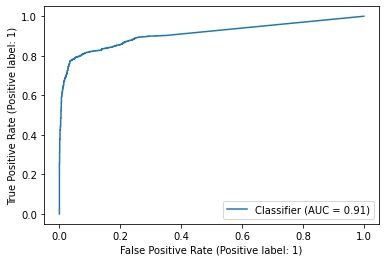

In [103]:
vote_threshold = 6 # number of spam votes needed to declare an email to be spam
sortarray = probarray_nc
spamprobs = np.zeros(num_emails)
for i in range(num_emails):
    sortarray[i] = np.sort(sortarray[i])
    spamprobs[i] = sortarray[i, 10 - vote_threshold]

trueresults = list(testdata.Spam)
RocCurveDisplay.from_predictions(trueresults, spamprobs)

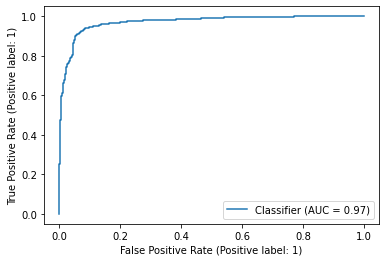

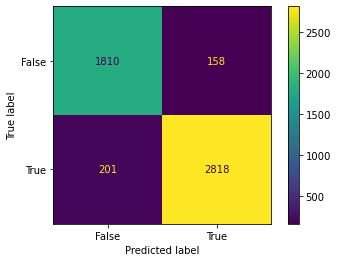

In [104]:
vote_threshold = 6 # number of spam votes needed to declare an email to be spam
sortarray = probarray_uc
spamprobs = np.zeros(num_emails)
for i in range(num_emails):
    sortarray[i] = np.sort(sortarray[i])
    spamprobs[i] = sortarray[i, 10 - vote_threshold]

trueresults = list(testdata.Spam)
RocCurveDisplay.from_predictions(trueresults, spamprobs)
ucresults = list(map(lambda x: x > 0.5, spamprobs))
ConfusionMatrixDisplay.from_predictions(trueresults, ucresults)

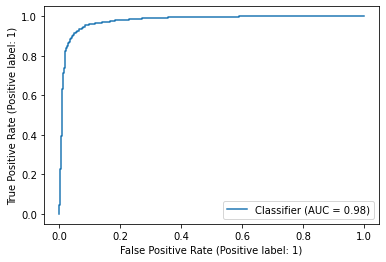

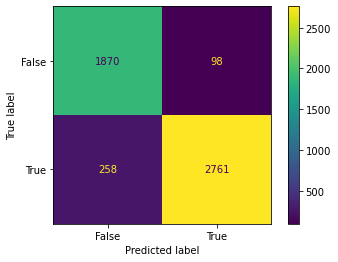

In [105]:
vote_threshold = 6 # number of spam votes needed to declare an email to be spam
sortarray = scorearray_svm
spamscores = np.zeros(num_emails)
for i in range(num_emails):
    sortarray[i] = np.sort(sortarray[i])
    spamscores[i] = sortarray[i, 10 - vote_threshold]

trueresults = list(testdata.Spam)
RocCurveDisplay.from_predictions(trueresults, spamscores)
svmresults = list(map(lambda x: x > 0, spamscores))
ConfusionMatrixDisplay.from_predictions(trueresults, svmresults)

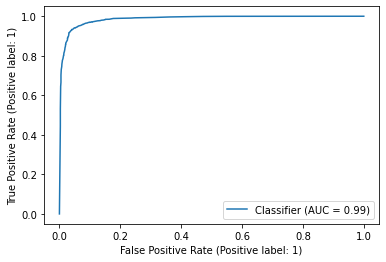

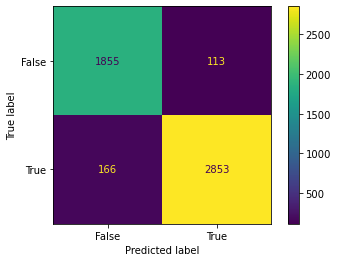

In [112]:
vote_threshold = 6 # number of spam votes needed to declare an email to be spam
sortarray = probarray_rf
spamprobs = np.zeros(num_emails)
for i in range(num_emails):
    sortarray[i] = np.sort(sortarray[i])
    spamprobs[i] = sortarray[i, 10 - vote_threshold]

trueresults = list(testdata.Spam)
RocCurveDisplay.from_predictions(trueresults, spamprobs)
roc_auc_score(trueresults, spamprobs)
rfresults = list(map(lambda x: x > 0.5, spamprobs))
ConfusionMatrixDisplay.from_predictions(trueresults, rfresults)

We now perform all of these calculations using the other four folds from earlier: (warning! this will take a very long time to run, multiple hours)

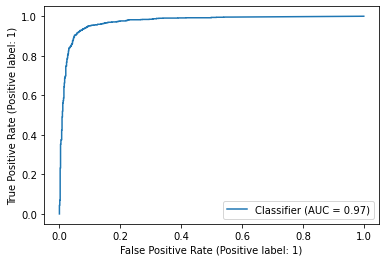

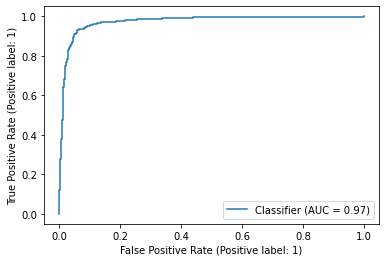

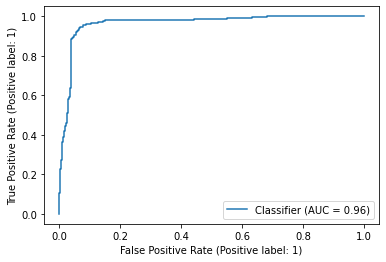

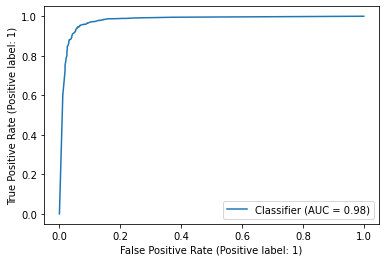

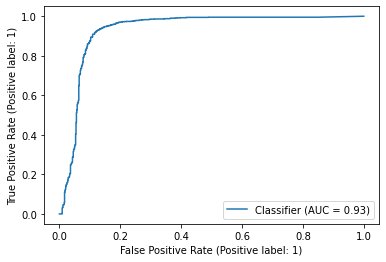

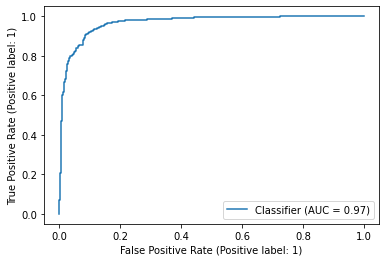

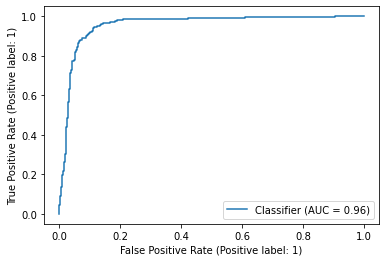

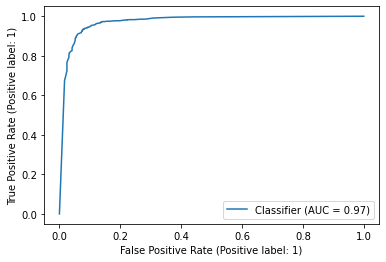

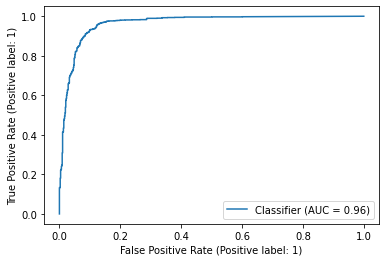

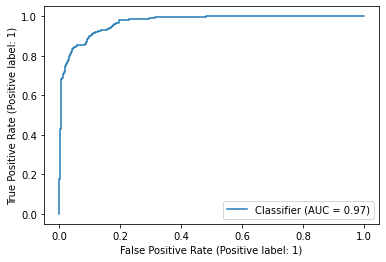

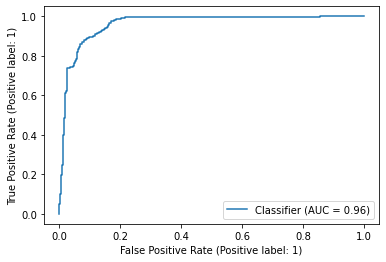

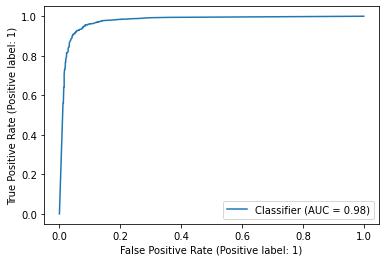

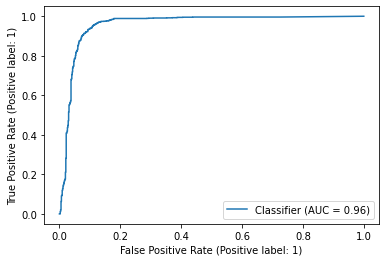

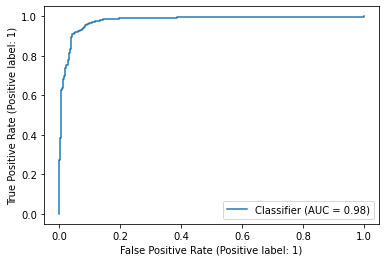

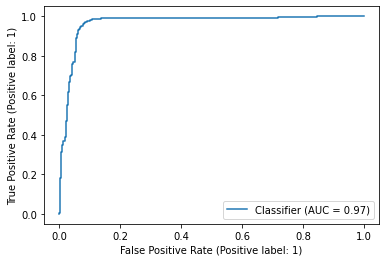

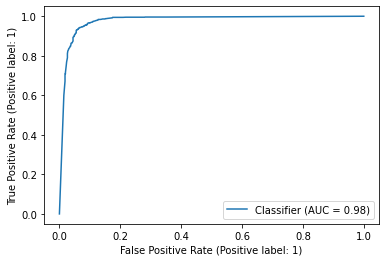

In [61]:
topic_models_cross = [topic_models, [], [], [], []]
dictionaries_cross = [dictionaries, [], [], [], []]
nc_classifiers_cross = [nc_classifiers, [], [], [], []]
uc_classifiers_cross = [uc_classifiers, [], [], [], []]
svm_classifiers_cross = [svm_classifiers, [], [], [], []]
rf_classifiers_cross = [rf_classifiers, [], [], [], []]
bestsplits_nc = [bestsplit_nc, None, None, None, None]
bestsplits_uc = [bestsplit_uc, None, None, None, None]
bestsplits_svm = [bestsplit_svm, None, None, None, None]
bestsplits_rf = [bestsplit_rf, None, None, None, None]

for i in range(1, 5):
    train, test = outerfolds[i]
    innerfolds = kf2.split(train)
    
    bestauc_nc = 0
    bestauc_uc = 0
    bestauc_svm = 0
    bestauc_rf = 0
    
    traindata = data.loc[train]
    traindata.reset_index(drop=True, inplace=True)
    j = 0
    for fold in innerfolds:

        innertrain, verify = fold
        innertraindata = traindata.loc[innertrain]
        testdata = traindata.loc[verify]
        dictionary = corpora.Dictionary(innertraindata.Lemmatized)
        dictionary.filter_extremes(no_below=15, no_above=0.5)
        dictionaries_cross[i].append(dictionary)
        traincorpus = list(map(dictionary.doc2bow, innertraindata.Lemmatized))
        testcorpus = list(map(dictionary.doc2bow, testdata.Lemmatized))
        hdp = HdpModel(traincorpus, dictionary, random_state=63)
        topic_models_cross[i].append(hdp)
        traindist = list(hdp[traincorpus])
        testdist = list(hdp[testcorpus])
        numtopics = len(hdp.get_topics())
        trainarray = distarray(traindist, numtopics)
        testarray = distarray(testdist, numtopics)
        trueresults = list(testdata.Spam)
    
        nc = naive_classifier(trainarray, list(innertraindata.Spam), threshold=spamproportion)
        nc_classifiers_cross[i].append(nc)
        spamprobs = list(map(nc, testarray))
        #testresults = list(map(lambda x: x > 0.5, spamprobs))
        auc = roc_auc_score(trueresults, spamprobs)
        if auc > bestauc_nc:
            bestauc_nc = auc
            bestsplits_nc[i] = j
        
        uc = upgraded_classifier(trainarray, list(innertraindata.Spam))
        uc_classifiers_cross[i].append(uc)
        spamprobs = list(map(uc, testarray))
        #testresults = list(map(lambda x: x > 0.5, spamprobs))
        auc = roc_auc_score(trueresults, spamprobs)
        if auc > bestauc_uc:
            bestauc_uc = auc
            bestsplits_uc[i] = j

        svm = SVC(random_state=63)
        svm = svm.fit(trainarray, innertraindata.Spam)
        svm_classifiers_cross[i].append(svm)
        spamscores = svm.decision_function(testarray)
        #testresults = list(map(lambda x: x > 0.5, spamprobs))
        auc = roc_auc_score(trueresults, spamscores)
        if auc > bestauc_svm:
            bestauc_svm = auc
            bestsplits_svm[i] = j
        
        rf = RandomForestClassifier(random_state=63)
        rf = rf.fit(trainarray, innertraindata.Spam)
        rf_classifiers_cross[i].append(rf)
        spamprobs = list(map(lambda x: x[1], rf.predict_proba(testarray)))
        #testresults = list(map(lambda x: x > 0.5, spamprobs))
        auc = roc_auc_score(trueresults, spamprobs)
        if auc > bestauc_rf:
            bestauc_rf = auc
            bestsplits_rf[i] = j

        j += 1
    
    RocCurveDisplay.from_predictions(true_nc, test_nc)
    RocCurveDisplay.from_predictions(true_uc, test_uc)
    RocCurveDisplay.from_predictions(true_svm, test_svm)
    RocCurveDisplay.from_predictions(true_rf, test_rf)

In [120]:
fold_num = 4

testdata = data.loc[outerfolds[fold_num][1]]
corpus = list(map(dictionaries_cross[fold_num][bestsplits_rf[fold_num]].doc2bow, testdata.Lemmatized))
dist = list(topic_models_cross[fold_num][bestsplits_rf[fold_num]][corpus])
numtopics = len(topic_models_cross[fold_num][bestsplits_rf[fold_num]].get_topics())
array = distarray(dist, numtopics)
trueresults = list(testdata.Spam)

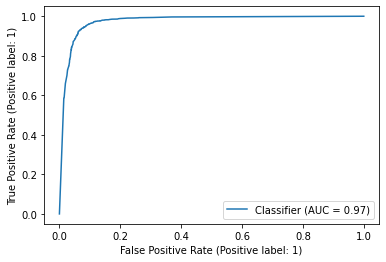

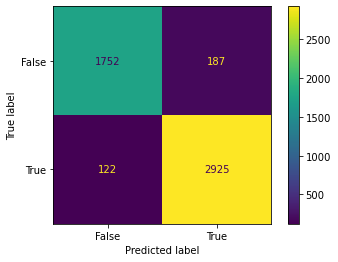

In [119]:
spamprobs = list(map(lambda x: x[1], rf_classifiers_cross[fold_num][bestsplits_rf[fold_num]].predict_proba(array)))
RocCurveDisplay.from_predictions(trueresults, spamprobs)
rf_results = list(map(lambda x: x > 0.5, spamprobs))
ConfusionMatrixDisplay.from_predictions(trueresults, rf_results)